In [1]:
# !pip install -e .

In [2]:
from deeplens.utils.analysis import plot_topk_distribution, get_top_k_tokens, generate_feature_heatmap
from deeplens.pipeline import pipeline

In [3]:
original, original_output, modified_output = pipeline(
    text="He said he would",
    hf_model="gpt2",
    layer=3,
    sae_model="/Users/inigoparra/Desktop/deeplens/demo/model/best_model.pt",
    sae_config="/Users/inigoparra/Desktop/deeplens/demo/config.yaml",
    feature=0,
    alpha=1000.0,
    tok_position=-1,
    generate=False,
    temperature=1.0
)

Running on device: mps
Running on device: mps
Running on device: mps


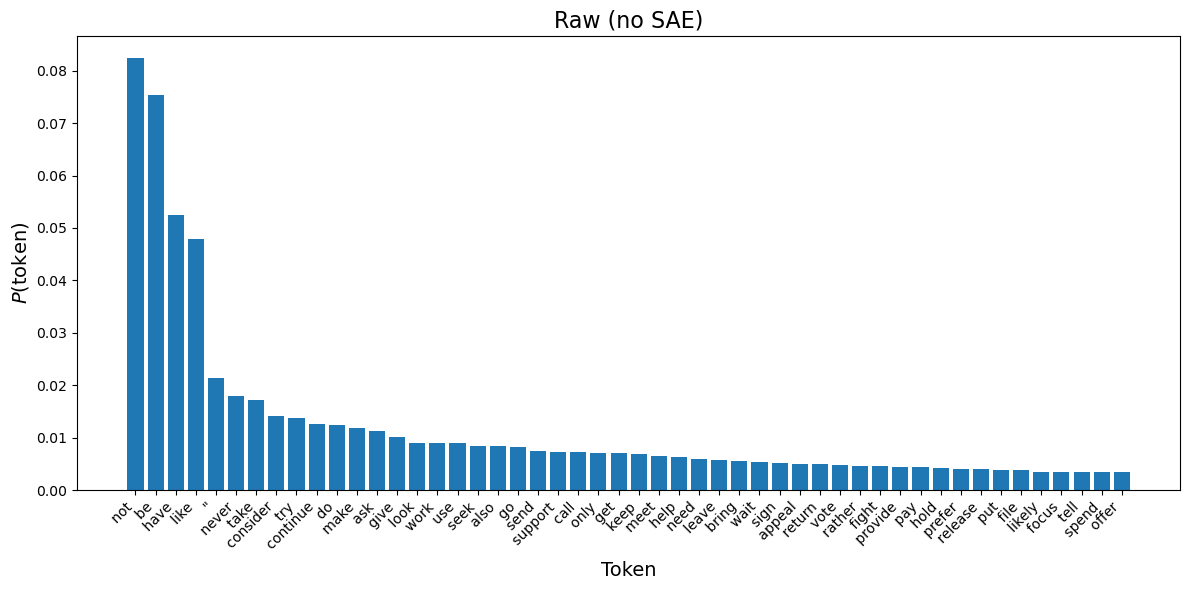

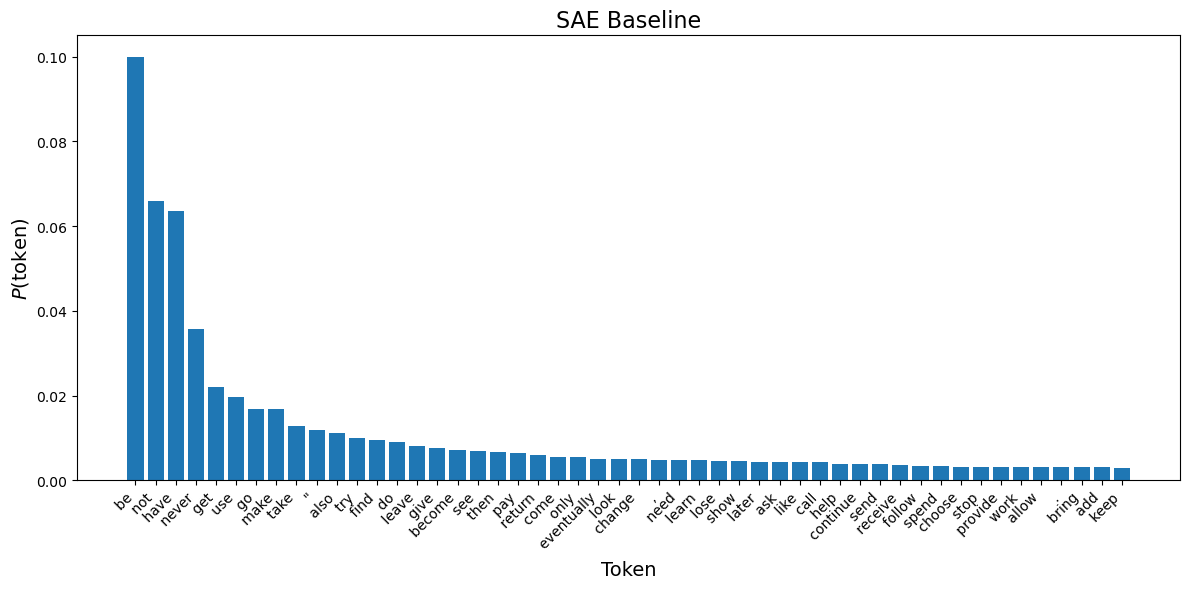

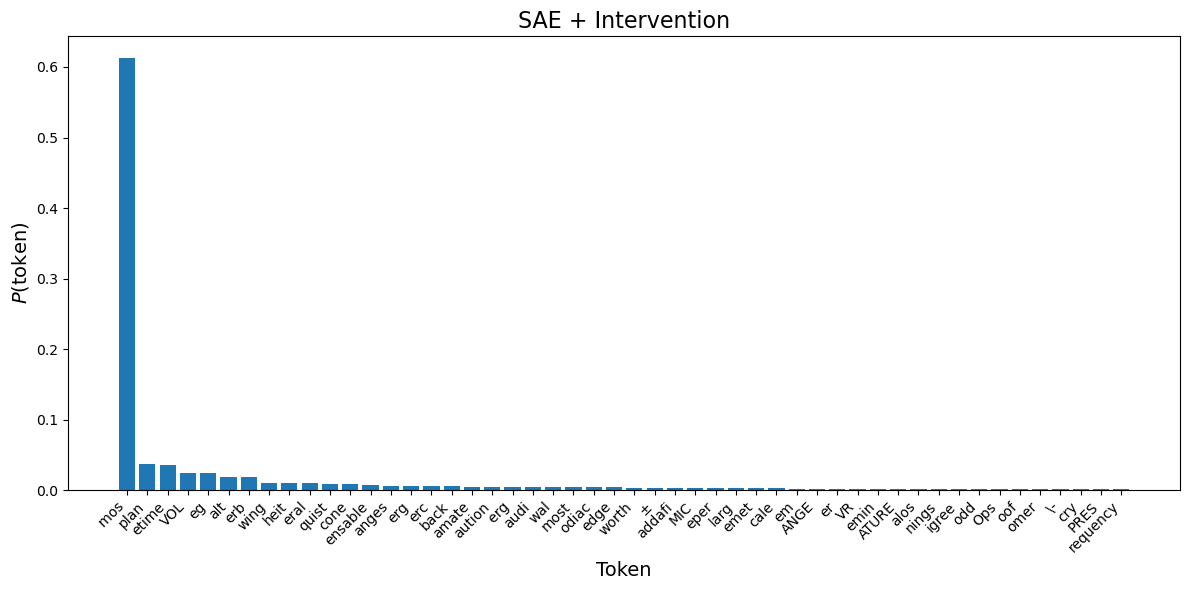

In [4]:
plot_topk_distribution(
    original, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="Raw (no SAE)"
)

plot_topk_distribution(
    original_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE Baseline"
)

plot_topk_distribution(
    modified_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE + Intervention"
)

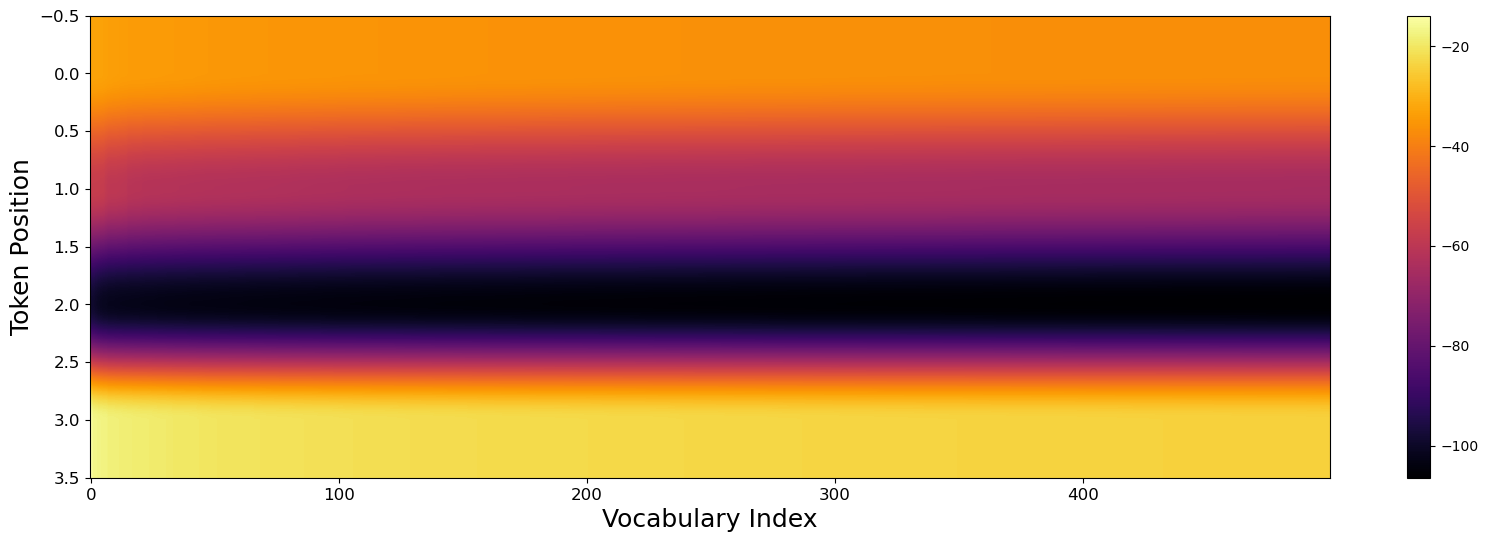

In [17]:
generate_feature_heatmap(
    modified_output,
    k=500
)

In [6]:
results = get_top_k_tokens(
    modified_output,
    k=5,
    tokenizer="gpt2",
    verbose=False,
    to_dataframe=True
)
results

,position,rank,token,probability
0,0,1,.,4.362371e-09
1,0,2,",",4.176075e-09
2,0,3,of,3.674606e-09
3,0,4,-,3.448077e-09
4,0,5,\n,3.437112e-09
5,1,1,that,8.553531e-20
6,1,2,.,8.059981e-20
7,1,3,:,7.381879e-20
8,1,4,the,6.846578e-20
9,1,5,",",5.942287e-20


In [7]:
from deeplens.extractor import ExtractSingleSample
from deeplens.intervene import InterveneFeatures

def get_most_active_features(
        sentences: list[str], 
        hf_model: str,
        sae_model: str,
        sae_config: str,
        layer: int, 
        k: int | None = None
    ):
    mlp_extractor = ExtractSingleSample(hf_model=hf_model, layer=layer)
    sae_features_extractor = InterveneFeatures(
        sae_model=sae_model,
        sae_config=sae_config,
    )
    features = []
    for sent in sentences:
        acts = mlp_extractor.get_mlp_acts(sample=sent)
        for i in range(acts.shape[0]):
            feats = sae_features_extractor.get_alive_features(activations=acts, token_position=i, k=k)
            features.append(feats.cpu())

    return features


sentences = [
    "What did you do?",
    "What have you done?",
    "What we did was amazing",
    "What came after was unexpected"
]

feats = get_most_active_features(
    sentences, 
    hf_model="gpt2",
    layer=3,
    sae_model="/Users/inigoparra/Desktop/deeplens/demo/model/best_model.pt", 
    sae_config="/Users/inigoparra/Desktop/deeplens/demo/config.yaml",
    k=5
)

feats

Running on device: mps
Running on device: mps


[tensor([16227, 23665, 16751,    32, 18845]),
 tensor([16631, 17134, 12279, 21583, 18033]),
 tensor([14111,  7323, 16052, 10996, 15736]),
 tensor([10996, 16631,  8993, 12803,  3515]),
 tensor([16734, 14122,  5253, 17031, 19991]),
 tensor([16227, 23665, 16751,    32, 18845]),
 tensor([10747, 17134, 12179, 16631, 12279]),
 tensor([23991, 10996,  3241, 14111, 16199]),
 tensor([ 8993, 17939, 10996, 18750, 16792]),
 tensor([16734, 14122, 21140, 12416,  1147]),
 tensor([16227, 23665, 16751,    32, 18845]),
 tensor([17134, 23749, 16631, 10747, 15736]),
 tensor([16631, 18750,  7841, 23706,  2344]),
 tensor([17593, 19109, 16792, 21272,  6059]),
 tensor([12556,  1223,  8576,   273,   186]),
 tensor([16227, 23665, 16751,    32, 18845]),
 tensor([12803, 12279, 17134,  5253,    65]),
 tensor([12110, 13942, 16631, 19905,  5026]),
 tensor([ 5253, 17593, 20804,  7323, 19416]),
 tensor([ 1354,  9567, 10199, 12110,  4273])]